In [4]:
!pip install pandas numpy matplotlib seaborn tqdm sklearn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [21]:
!git add .
!git commit -m "update"
!git push

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@VM-20-2-centos.(none)')
Everything up-to-date


In [2]:
# data analysis and preparing
import pandas as pd
import math
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree
from sklearn.metrics import auc, roc_curve, confusion_matrix, f1_score

In [3]:
# Read data file
df = pd.read_csv('kickstarter201801.csv')

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,09/10/2015,1000.0,11/08/2015 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,01/11/2017,30000.0,02/09/2017 04:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,26/02/2013,45000.0,12/01/2013 00:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,16/04/2012,5000.0,17/03/2012 03:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,29/08/2015,19500.0,04/07/2015 08:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                378661 non-null  int64  
 1   name                              378657 non-null  object 
 2   category                          378661 non-null  object 
 3   main_category                     378661 non-null  object 
 4   currency                          378661 non-null  object 
 5   deadline                          378661 non-null  object 
 6   goal                              378661 non-null  float64
 7   launched                          378661 non-null  object 
 8   pledged                           378661 non-null  float64
 9   state                             378661 non-null  object 
 10  backers                           378661 non-null  int64  
 11  country                           378661 non-null  o

In [6]:
state_value_counts = df['state'].value_counts()

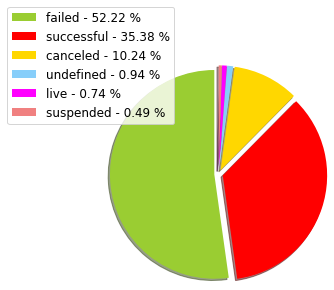

In [7]:
# fig1, ax1 = plt.subplots()
# ax1.pie(state_value_counts.values, labels=state_value_counts.index, autopct='%1.1f%%',
#         shadow=True, startangle=100)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
x = np.char.array([str(i) for i in state_value_counts.index])
y = np.array(state_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(state_value_counts.index)]
explode = [0.05] * len(state_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

# Unbalance data

In [8]:
df.isnull().sum()

ID                                     0
name                                   4
category                               0
main_category                          0
currency                               0
deadline                               0
goal                                   0
launched                               0
pledged                                0
state                                  0
backers                                0
country                                0
usd pledged                         3797
usd_pledged_realised at deadline       0
usd_goal_real_at_start                 0
dtype: int64

In [9]:
# drop ID and name, since they are unique value for each one.
df = df.drop(["ID", "name"], axis=1)

In [10]:
#dealing with missing data
df['usd pledged'].fillna(method='pad', inplace=True)
# Removing the four NA record from our dataset
df.dropna(axis=0, inplace=True)
df.isnull().sum()

category                            0
main_category                       0
currency                            0
deadline                            0
goal                                0
launched                            0
pledged                             0
state                               0
backers                             0
country                             0
usd pledged                         0
usd_pledged_realised at deadline    0
usd_goal_real_at_start              0
dtype: int64

In [11]:
df["duration"] = (pd.to_datetime(df.deadline, format="%d/%m/%Y") - pd.to_datetime(df.launched,
                                                                                  format="%d/%m/%Y %H:%M")).apply(
    lambda x: x.days)
df["duration"]

0         58
1         59
2         44
3         29
4         55
          ..
378656    29
378657    26
378658    45
378659    30
378660    27
Name: duration, Length: 378661, dtype: int64

In [12]:
df["completeRatio"] = df['usd_pledged_realised at deadline'] / df['usd_goal_real_at_start']
df["completeRatio"]

0         0.000000
1         0.080700
2         0.004889
3         0.000200
4         0.065795
            ...   
378656    0.000500
378657    0.103333
378658    0.001333
378659    0.013333
378660    0.262000
Name: completeRatio, Length: 378661, dtype: float64

In [13]:
# Drop Date
df = df.drop(["deadline", "launched"], axis=1)
df = df.drop(['pledged', 'goal'],axis=1)

In [14]:
df.head()

,category,main_category,currency,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start,duration,completeRatio
0,Poetry,Publishing,GBP,failed,0,GB,0.0,0.0,1533.95,58,0.000000
1,Narrative Film,Film & Video,USD,failed,15,US,100.0,2421.0,30000.00,59,0.080700
2,Narrative Film,Film & Video,USD,failed,3,US,220.0,220.0,45000.00,44,0.004889
3,Music,Music,USD,failed,1,US,1.0,1.0,5000.00,29,0.000200
4,Film & Video,Film & Video,USD,canceled,14,US,1283.0,1283.0,19500.00,55,0.065795


In [15]:
# Transform Category
categoryTransformTable = {}
categorySet = set(df['category'])
for index, i in enumerate(categorySet):
    categoryTransformTable[i] = index

stateTransformTable = {}
stateSet = set(df['state'])
for index, i in enumerate(stateSet):
    stateTransformTable[i] = index
#
currencyTransformTable = {}
currencySet = set(df['currency'])
for index, i in enumerate(currencySet):
    currencyTransformTable[i] = index

countryTransformTable = {}
countrySet = set(df['country'])
for index, i in enumerate(countrySet):
    countryTransformTable[i] = index

main_categoryTransformTable = {}
main_categorySet = set(df['main_category'])
for index, i in enumerate(main_categorySet):
    main_categoryTransformTable[i] = index

num_encode = {
    'state': stateTransformTable,
    'category': categoryTransformTable,
    'currency': currencyTransformTable,
    'country': countryTransformTable,
    'main_category': main_categoryTransformTable,
}
# Do Transformation
df.replace(num_encode, inplace=True)

In [16]:
# main_category = pd.get_dummies(df['main_category'], prefix='main_category')
# category = pd.get_dummies(df['category'], prefix='category')
# currency = pd.get_dummies(df['currency'], prefix='currency')
# country = pd.get_dummies(df['category'], prefix='country')
#
# df = pd.concat([df, main_category, category, currency, country], axis=1)
# df = df.drop(['main_category', 'category', 'currency', 'country'], axis=1)

In [17]:
df.head()

,category,main_category,currency,state,backers,country,usd pledged,usd_pledged_realised at deadline,usd_goal_real_at_start,duration,completeRatio
0,127,0,7,2,0,14,0.0,0.0,1533.95,58,0.000000
1,111,11,4,2,15,22,100.0,2421.0,30000.00,59,0.080700
2,111,11,4,2,3,22,220.0,220.0,45000.00,44,0.004889
3,89,6,4,2,1,22,1.0,1.0,5000.00,29,0.000200
4,32,11,4,0,14,22,1283.0,1283.0,19500.00,55,0.065795


In [18]:
# Split data into training, validation and test sets
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

combined = [train, val, test]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

print(f"Testing Model {KNeighborsClassifier.__name__}")
X_train, X_test = train.drop(["state"], axis=1), test.drop(["state"], axis=1)
y_train, y_test = train['state'], test['state']
neighbor_size = [3, 5, 7, 9, 11, 13]
metricNames = ["euclidean", "manhattan", "chebyshev"]
result = {}

for k in metricNames:
    result[k] = {}
    for neighbors in neighbor_size:
        print(f"Testing <metric: {k}, neighborSize: {neighbors}>: ", end="")
        knn = KNeighborsClassifier(n_neighbors=neighbors, metric=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")
        print(f"Result: Accuracy {accuracy}, F1 {f1}")
        result[k][neighbors] = {
            "Accuracy": accuracy,
            "F1": f1
        }

Testing Model KNeighborsClassifier
Testing <metric: euclidean, neighborSize: 3>: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



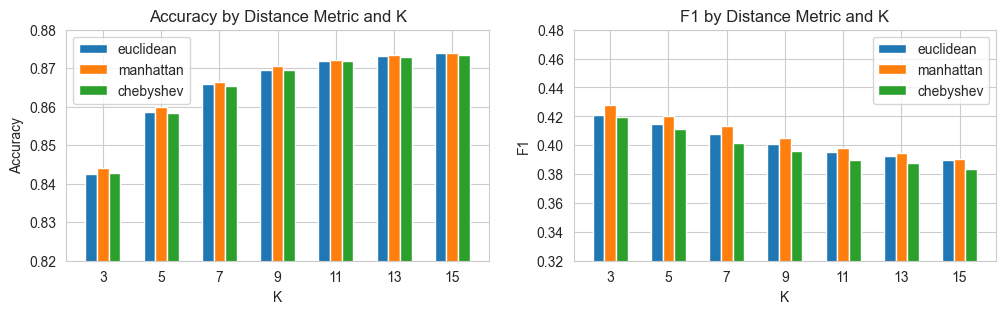

In [349]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax1.bar(x - width + (width) * (index), [neighborResult[i]['Accuracy'] for i in neighborResult], width, label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('K')
ax1.set_title('Accuracy by Distance Metric and K')
ax1.set_xticks(x, labels)
ax1.set_ylim([0.82, 0.88])
ax1.legend()

labels = neighbor_size
width = 0.2  # the width of the bars
x = np.arange(len(labels))  # the label locations
for index, metricName in enumerate(result):
    neighborResult = result[metricName]
    rect = ax2.bar(x - width + (width) * (index), [neighborResult[i]['F1'] for i in neighborResult], width, label=metricName)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('F1')
ax2.set_xlabel('K')
ax2.set_title('F1 by Distance Metric and K')
ax2.set_xticks(x, labels)
ax2.set_ylim([0.32, 0.48])
ax2.legend()


plt.show()